# Fitting $R_t$ From COVID-19 Infection Data

This notebook was originally based off the `Realtime R0.ipynb` calculation, but intended to produce a Bayesian posterior over the values of $R_t$ *and* $\sigma$ given the data instead of only fitting $R_t$ using a max-likelihood estimate for $\sigma$.  It has now diverged significantly; the underlying model is fairly similar to `Realtime Rt mcmc.ipynb`, but our data handling differs in that we do not attempt to account for delays between infection, onset of symptoms, and confirmation.  Instead, we are estimating $R_t$ *of confirmation* (roughly, the delay time from infection to confirmation is one to two weeks---so our estimate will lag the infection $R_t$ by a week or two).  

We use Stan to sample over the AR(1) prior for $R_t$ (increments are independent Gaussian variables) and also $\sigma$, the s.d. of the increment distribution. 

The [Stan](http://mc-stan.org) model we use for the sampling can be found in the `R0.stan` file in the current directory.

Note that our Python environment is captured in `environment.yml`; issuing
```zsh
conda env create -f environment.yml
```
should duplicate it on your system.  You can then activate it via 
```zsh
conda activate covid-19
```

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import datetime
import matplotlib.dates as md
import os
import os.path
import pandas as pd
import pystan
import scipy.stats as ss
import seaborn as sns
from tqdm import tqdm

sns.set_context('notebook')
sns.set_palette('colorblind')

Download the dataset from https://covidtracking.com

In [3]:
url='https://covidtracking.com/api/v1/states/daily.csv'
states = pd.read_csv(url,
                     usecols=['date', 'state', 'positive', 'negative'],
                     parse_dates=['date'],
                     index_col=['state', 'date'],
                     squeeze=True).sort_index()
states['total'] = states['positive'] + states['negative']

Compile the Stan model that simultaneously fits for $R_t$ and $\sigma$.  Our model differs from that in http://rt.live in several respects.  Trivially, we choose different priors on $\sigma$ (the scatter from one day to the next in the imposed prior on $R_t$), the first day's infection count, and $R_1$.  

Less trivially, based on the discussion [here](https://github.com/k-sys/covid-19/issues/45), we have moved to a binomial measurement model (our previous Poisson model is still around in `R0.stan`).  Here is a motivating "derivation" of the model.  We assume that on any day the number of infected (in principle getting a positive test result, actually---there is a lag between infection, symptoms, and positive tests of a week or two; but for now we will use the "infected" language) in a region is given by
$$
n_i = n_{i-1} \exp\left( \frac{R_i - 1}{\tau} \right),
$$
where $n_{i}$ is the number of infected on day $i$, $R_i$ is the reproduction number on day $i$, and $\tau$ is the serial time (the length of time over which a single infected individual infects $R_t$ others).  If we now assume that the number of people in the population exhibiting symptoms that would permit testing (or otherwise in a class that can be tested), but do *not* have COVID19 (maybe they have the flu, maybe they have some other condition, maybe they have access to tsets for some reason---health care professional, for example), $m$, is approximately constant, and that the subset of $n_i$ and $m$ that are tested on any day is a fair sampling of the full group of size $n_i + m$ (this assumption is almost certainly false!), then the number of positive tests will be given by a Binomial 
$$
n_{+,i} \sim \mathrm{Binom}\left( p_i, N_\mathrm{test} \right)
$$
where $p_i = n_i / \left( n_i + m \right)$.  From this last relation, we see that 
$$
\mathrm{logit} p_i \equiv \log p_i - \log \left( 1 - p_i \right) = \log n_i - \log m = \mathrm{logit} p_{i-1} + \frac{R_i - 1}{\tau};
$$
that is, the log-odds of a positive test move linearly in time, or the odds of a positive test move exponentially.  Effectively, we are using the total number of tests done to scale the expected number of positive results, so that jumps in testing numbers do not artificially lead us to conclude that there is a jump in actual infections.

One final complication is that we marginalize over the serial number, using a log-normal distribution that matches to a measured mean and s.d.  

In [4]:
model = pystan.StanModel(file='R0-binomial.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c37ba29c7d19fd931585b0bc19360202 NOW.


We marginalize over the serial time, based on the mean and standard deviation reported at https://epiforecasts.io/covid/ (which, in turn, come from [Nishiura, Linton, & Akhmetzhanov (2020)](https://doi.org/10.1101/2020.02.03.20019497)).

In [5]:
serial_mean = 4.7
serial_std = 2.9

serial_mu = log(serial_mean) - 0.5*log1p(serial_std*serial_std/(serial_mean*serial_mean))
serial_sigma = sqrt(log1p(serial_std*serial_std/(serial_mean*serial_mean)))

d = ss.lognorm(serial_sigma, scale=exp(serial_mu))

print('mean and s.d. of fitted log-normal for tau are {:.1f}, {:.1f}'.format(d.mean(), d.std()))

mean and s.d. of fitted log-normal for tau are 4.7, 2.9


Smoothing has been a constant issue; there are weird day-by-day trends in the data.  For example, here is the time-series of log-odds for NY:

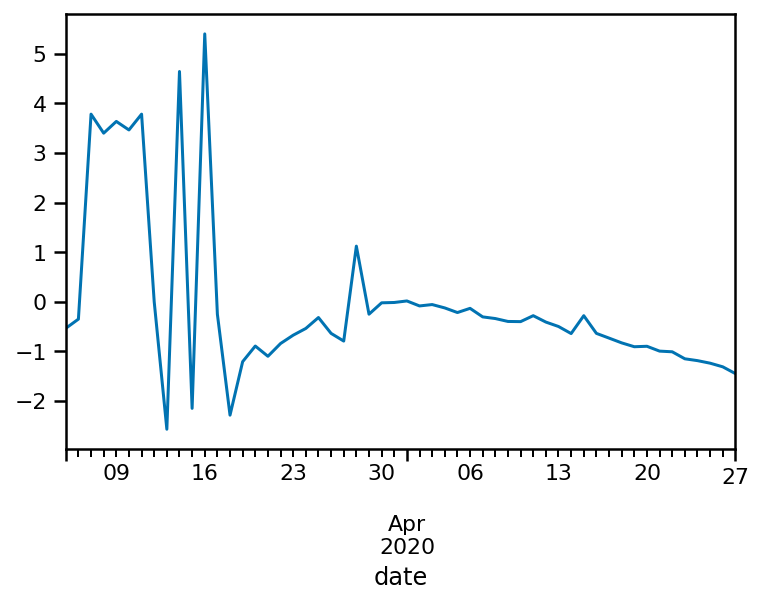

In [6]:
ny = states.loc['NY']

(log(ny['positive'].diff().dropna() + 1) - log(ny['total'].diff().dropna() - ny['positive'].diff().dropna() + 1)).plot()

There is some total junk (low numbers!) in the early data, followed by a pretty reasonable rising and then falling trend (yeah!).  But even in the later data, there are some individual day outliers.  In any case, the the distribution of time between infection to symptoms to confirmation via test is quite broad (at least a week or two, with s.d. maybe one week) that it seems reasonable to smooth the time-series some.  In the past I had used an exponential filter, but that does not provide very much smoothing of the high-frequency components unless the timescale is very long; a Gaussian filter is much smoother.  Convolving in the time-domain with a Gaussian 
$$
g(\tau) = \exp\left[ -\frac{\tau^2}{2 \sigma^2} \right]
$$
is equivalent to multiplication in the frequency domain by 
$$
\tilde{g}(f) \propto \exp\left[ -\frac{f^2}{2 \kappa^2} \right],
$$
with width 
$$
\kappa = \frac{1}{2\pi \sigma}.
$$
If we want to suppress fluctuations on longer than 7-day timescales by a factor of 10 (this may be too much smoothing, but let's go with it for now), then we want to choose 
$$
\frac{\left( 1 / 7 \, \mathrm{d} \right)^2}{2 \kappa^2} = \log 10,
$$
or 
$$
\sigma \simeq 2.4 \, \mathrm{d}.
$$

Lately http://rt.live has been using a method for projecting cases back to time of onset that effectively filters on a ~7 day timescale; a discussion, including my rationale for not using that method, can be found [here](https://github.com/k-sys/covid-19/issues/43).  Note that smoothing an exponential timeseries with another exponential *does not change the series timeconstant*, so we might think (hope?) that we are still estimating the local $R_t$ in this manner.

Note that the Gaussian filter is *acausal*; the comment [here](https://github.com/k-sys/covid-19/issues/30), argues for using a causal filter to preserve the "accumulative" property of Bayseian inference.  However, note that our prior on $R_t$ is *already* acausal because we fit $\sigma$ from the full data set.  

In [7]:
smooth_std = 2.4

## One State By Hand

Here we do my home state (NY) by hand, just to show aspects of the data processing, fitting, and plotting; stay tuned for the bulk run.  Note that we cut out samples from a time before the state has tested (cumulatively) 1000 people, since these are the "junk" above.

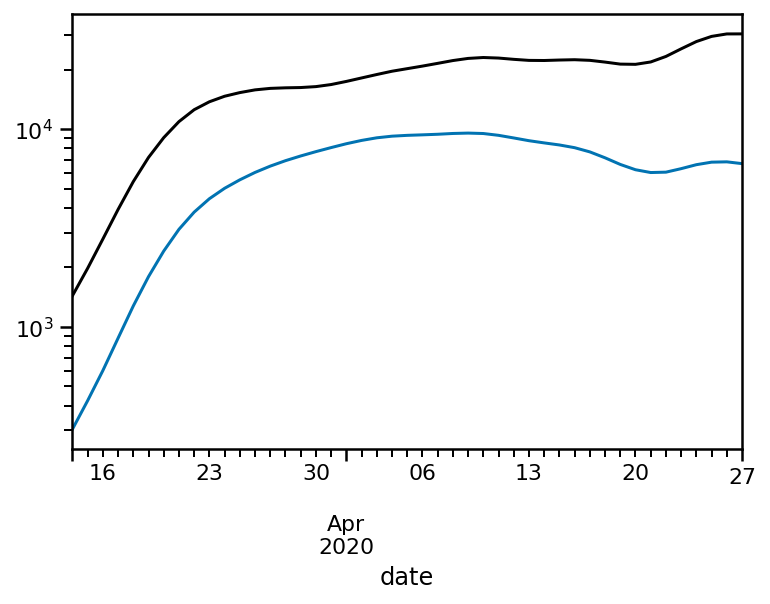

In [8]:
ny = states.loc['NY']
istart = np.where(ny['total'] > 1000)[0][0]
ny = ny.iloc[istart:]
pos = ny['positive'].diff().dropna().rolling(int(round(5*smooth_std)), min_periods=1, center=True, win_type='gaussian').mean(std=smooth_std)
tot = ny['total'].diff().dropna().rolling(int(round(5*smooth_std)), min_periods=1, center=True, win_type='gaussian').mean(std=smooth_std)

pos.plot()
tot.plot(color='k')

data = {
    'ndays': len(pos),
    'k': pos.round().astype(np.int),
    'n': tot.round().astype(np.int),
    
    'tau_mu': serial_mu,
    'tau_sigma': serial_sigma,
    
    'sigma_mu': 0.5*log(2)/sqrt(7),
    'sigma_sigma': 1.0
}

yscale('log')

Run the fits, hinting to `arviz` that it should use the appropriate date-time coordinates for the expected number of counts and $R_t$.

In [9]:
fit_stan = model.sampling(data=data)
fit = az.from_pystan(fit_stan, 
                     coords={'dates': data['k'].index,
                             'Rt_dates': data['k'].index[1:]},
                     dims={'Rt': ['Rt_dates'],
                           'log_odds': ['dates']})

A quick traceplot, just because it looks pretty:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aaae4345a50>,
      dtype=object)

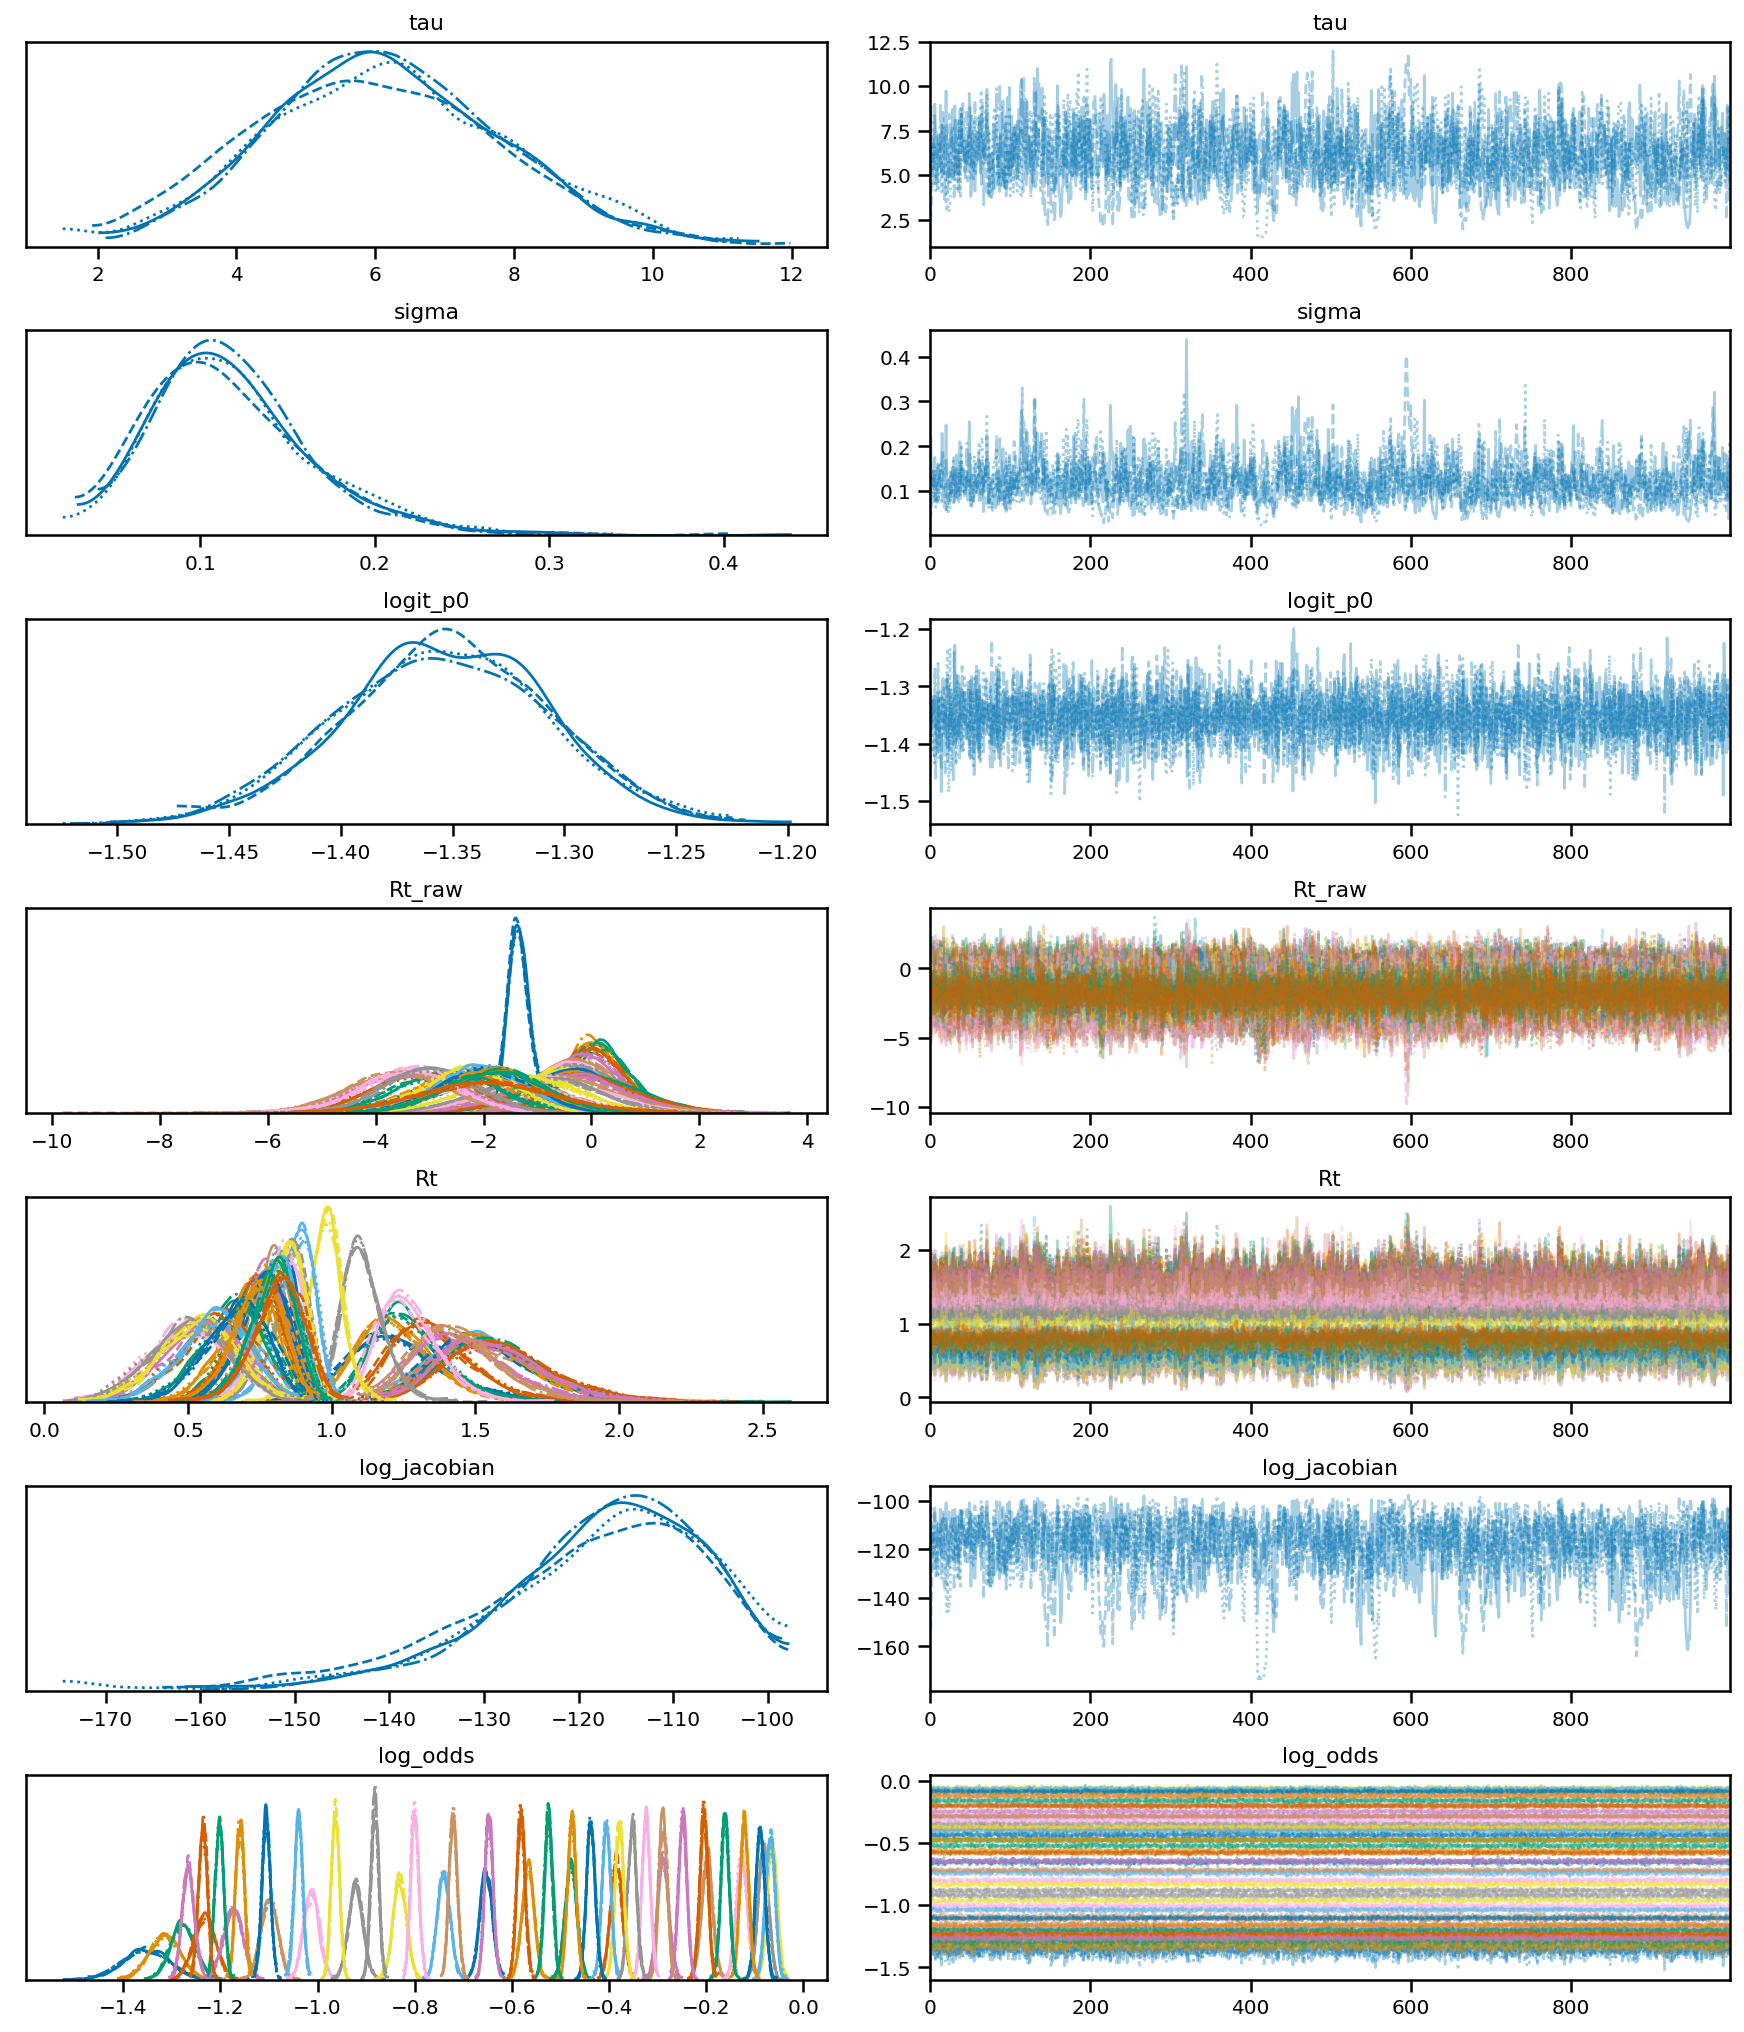

In [10]:
az.plot_trace(fit, compact=True)

(737496.85, 737544.15, 0.0, 3.0)

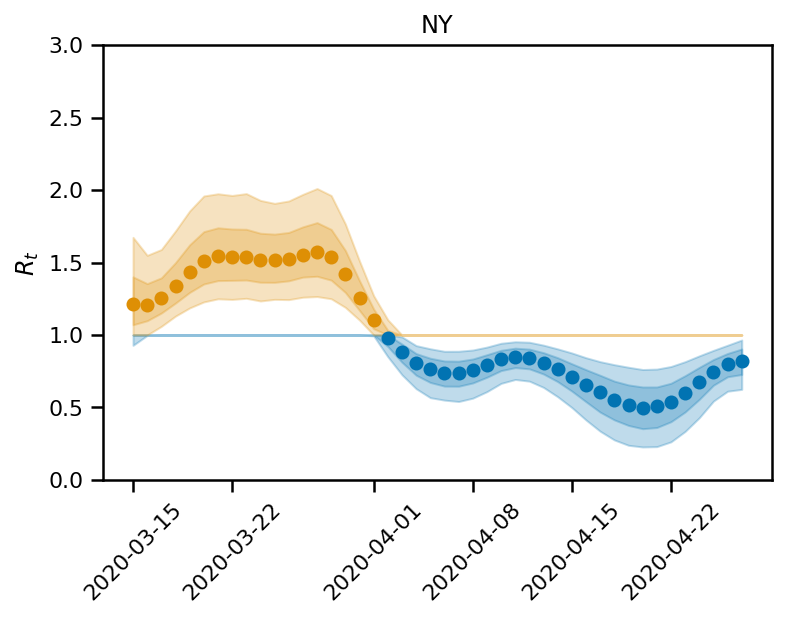

In [11]:
m = median(fit.posterior.Rt, axis=(0,1))
hh = percentile(fit.posterior.Rt, 97.5, axis=(0,1))
h = percentile(fit.posterior.Rt, 84, axis=(0,1))
l = percentile(fit.posterior.Rt, 16, axis=(0,1))
ll = percentile(fit.posterior.Rt, 2.5, axis=(0,1))

x = fit.posterior.Rt_dates.values

good_dates = m <= 1.0
bad_dates = m > 1.0

plot_date(x[good_dates], m[good_dates], xdate=True, color=sns.color_palette()[0])
fill_between(x, where(h<1, h, 1) , where(l<1, l, 1), alpha=0.25, color=sns.color_palette()[0])
fill_between(x, where(hh<1, hh, 1) , where(ll<1, ll, 1), alpha=0.25, color=sns.color_palette()[0])

plot_date(x[bad_dates], m[bad_dates], xdate=True, color=sns.color_palette()[1])
fill_between(x, where(h>1, h, 1) , where(l>1, l, 1), alpha=0.25, color=sns.color_palette()[1])
fill_between(x, where(hh>1, hh, 1) , where(ll>1, ll, 1), alpha=0.25, color=sns.color_palette()[1])

title('NY')

xticks(rotation=45)
ylabel(r'$R_t$')

axis(ymin=0, ymax=3)

Something interesting is happening here: we seem to be getting better inferences for $\tau$ (the serial time) than the prior.  This is, in principle, possible---for example, we should get very good inferences on $\tau$ if the positive rate declines significantly, since $R_t \geq 0$ implies that the most extreme decay is $\Lambda(t) \sim \exp\left( -t / \tau \right)$.  Posterior in blue, prior in black (recall that the prior is chosen so that it has the same mean and s.d. as the quoted interval for $\tau$ from previous research).

Before we make too much of this, we should probably check the effect of our smoothing, which suppresses changes on short timescales (we chose the smoothing time so that Fourier modes with frequencies larger than $1/\left( 7 \, \mathrm{d} \right)$ will be suppressed by an order of magnitude or more); this could be leading to the larger inference for $\tau$.  

Worth following up on later.

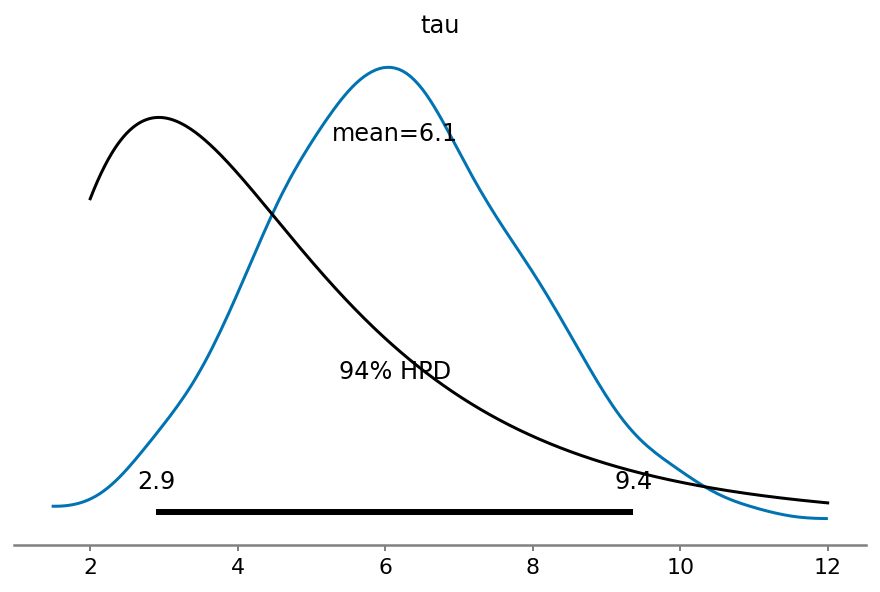

In [12]:
az.plot_posterior(fit, var_names='tau', )
xs = linspace(2, 12, 1024)
plot(xs, ss.lognorm(0.57, scale=exp(1.4)).pdf(xs), '-k')

## All States

In [13]:
def fit_state(states, state_key):
    st = states.loc[state_key]
    
    istart = np.where(st['total'] > 1000)[0][0]
    st = st.iloc[istart:]

    pos = st['positive'].diff().dropna().rolling(int(round(5*smooth_std)), min_periods=1, center=True, win_type='gaussian').mean(std=smooth_std)
    tot = st['total'].diff().dropna().rolling(int(round(5*smooth_std)), min_periods=1, center=True, win_type='gaussian').mean(std=smooth_std)
    
    data = {
        'ndays': len(pos),
        'k': pos.round().astype(np.int),
        'n': tot.round().astype(np.int),
        
        'tau_mu': serial_mu,
        'tau_sigma': serial_sigma,
        'sigma_mu': 0.5*log(2)/sqrt(7),
        'sigma_sigma': 1.0
    }
    
    if len(pos) == 0:
        raise RuntimeError("can't fit an empty data set")
    
    tries = 0
    iter = 2000
    thin = 1
    while tries < 3:
        fit = az.from_pystan(model.sampling(data=data, iter=iter, thin=thin), 
                             coords={'dates': pos.index,
                                     'Rt_dates': pos.index[1:]},
                             dims={'Rt': ['Rt_dates'],
                                   'log_odds': ['dates']})
        ess = az.ess(fit, var_names=['tau', 'sigma', 'logit_p0', 'Rt']).min()
        if ess.tau > 1e2 and ess.sigma > 1e2 and ess.logit_p0 > 1e2 and ess.Rt > 1e2 and np.all(az.bfmi(fit) > 0.2):
            break
        else:
            tries += 1
            iter *= 2
            thin *= 2
    
    return fit

We run the fit on each state (takes ten-twenty minutes on my MacBook); some states have no data, so we skip those.

In [ ]:
state_fits = {}
with tqdm(states.groupby(level=0)) as bar:
    for st, _ in bar.iterable:
        try:
            if np.all(np.isnan(states.loc[st]) | (states.loc[st] == 0)):
                bar.write('Skipping state: {:s}'.format(st))
                bar.update(1)
                continue
            state_fits[st] = fit_state(states, st)
            bar.update(1)
        except (RuntimeError, IndexError):
            bar.write('State {:s} failed with RuntimeError; skipping'.format(st))
            bar.update(1)
            continue

  5%|▌         | 3/56 [01:43<25:58, 29.41s/it]

State AS failed with RuntimeError; skipping


 48%|████▊     | 27/56 [10:04<10:23, 21.51s/it]

State MP failed with RuntimeError; skipping


 89%|████████▉ | 50/56 [18:56<02:29, 24.99s/it]

State VI failed with RuntimeError; skipping


 93%|█████████▎| 52/56 [19:15<01:21, 20.35s/it]

Save all the fits; use `load_state_fits` (untested) to load them back in.

In [20]:
def save_state_fits(fits, directory):
    try:
        os.makedirs(directory)
    except OSError:
        pass
    
    for k, f in fits.items():
        az.to_netcdf(f, os.path.join(directory, k + '.nc'))
def load_state_fits(directory):
    fits = {}
    for f in glob.glob(os.path.join(directory, '*.nc')):
        k = os.path.splitext(os.path.split(f)[1])[0]
        fits[k] = az.from_netcdf(f)

In [21]:
save_state_fits(state_fits, 'state_fits')

And make a plot that is similar to the one at http://rt.live

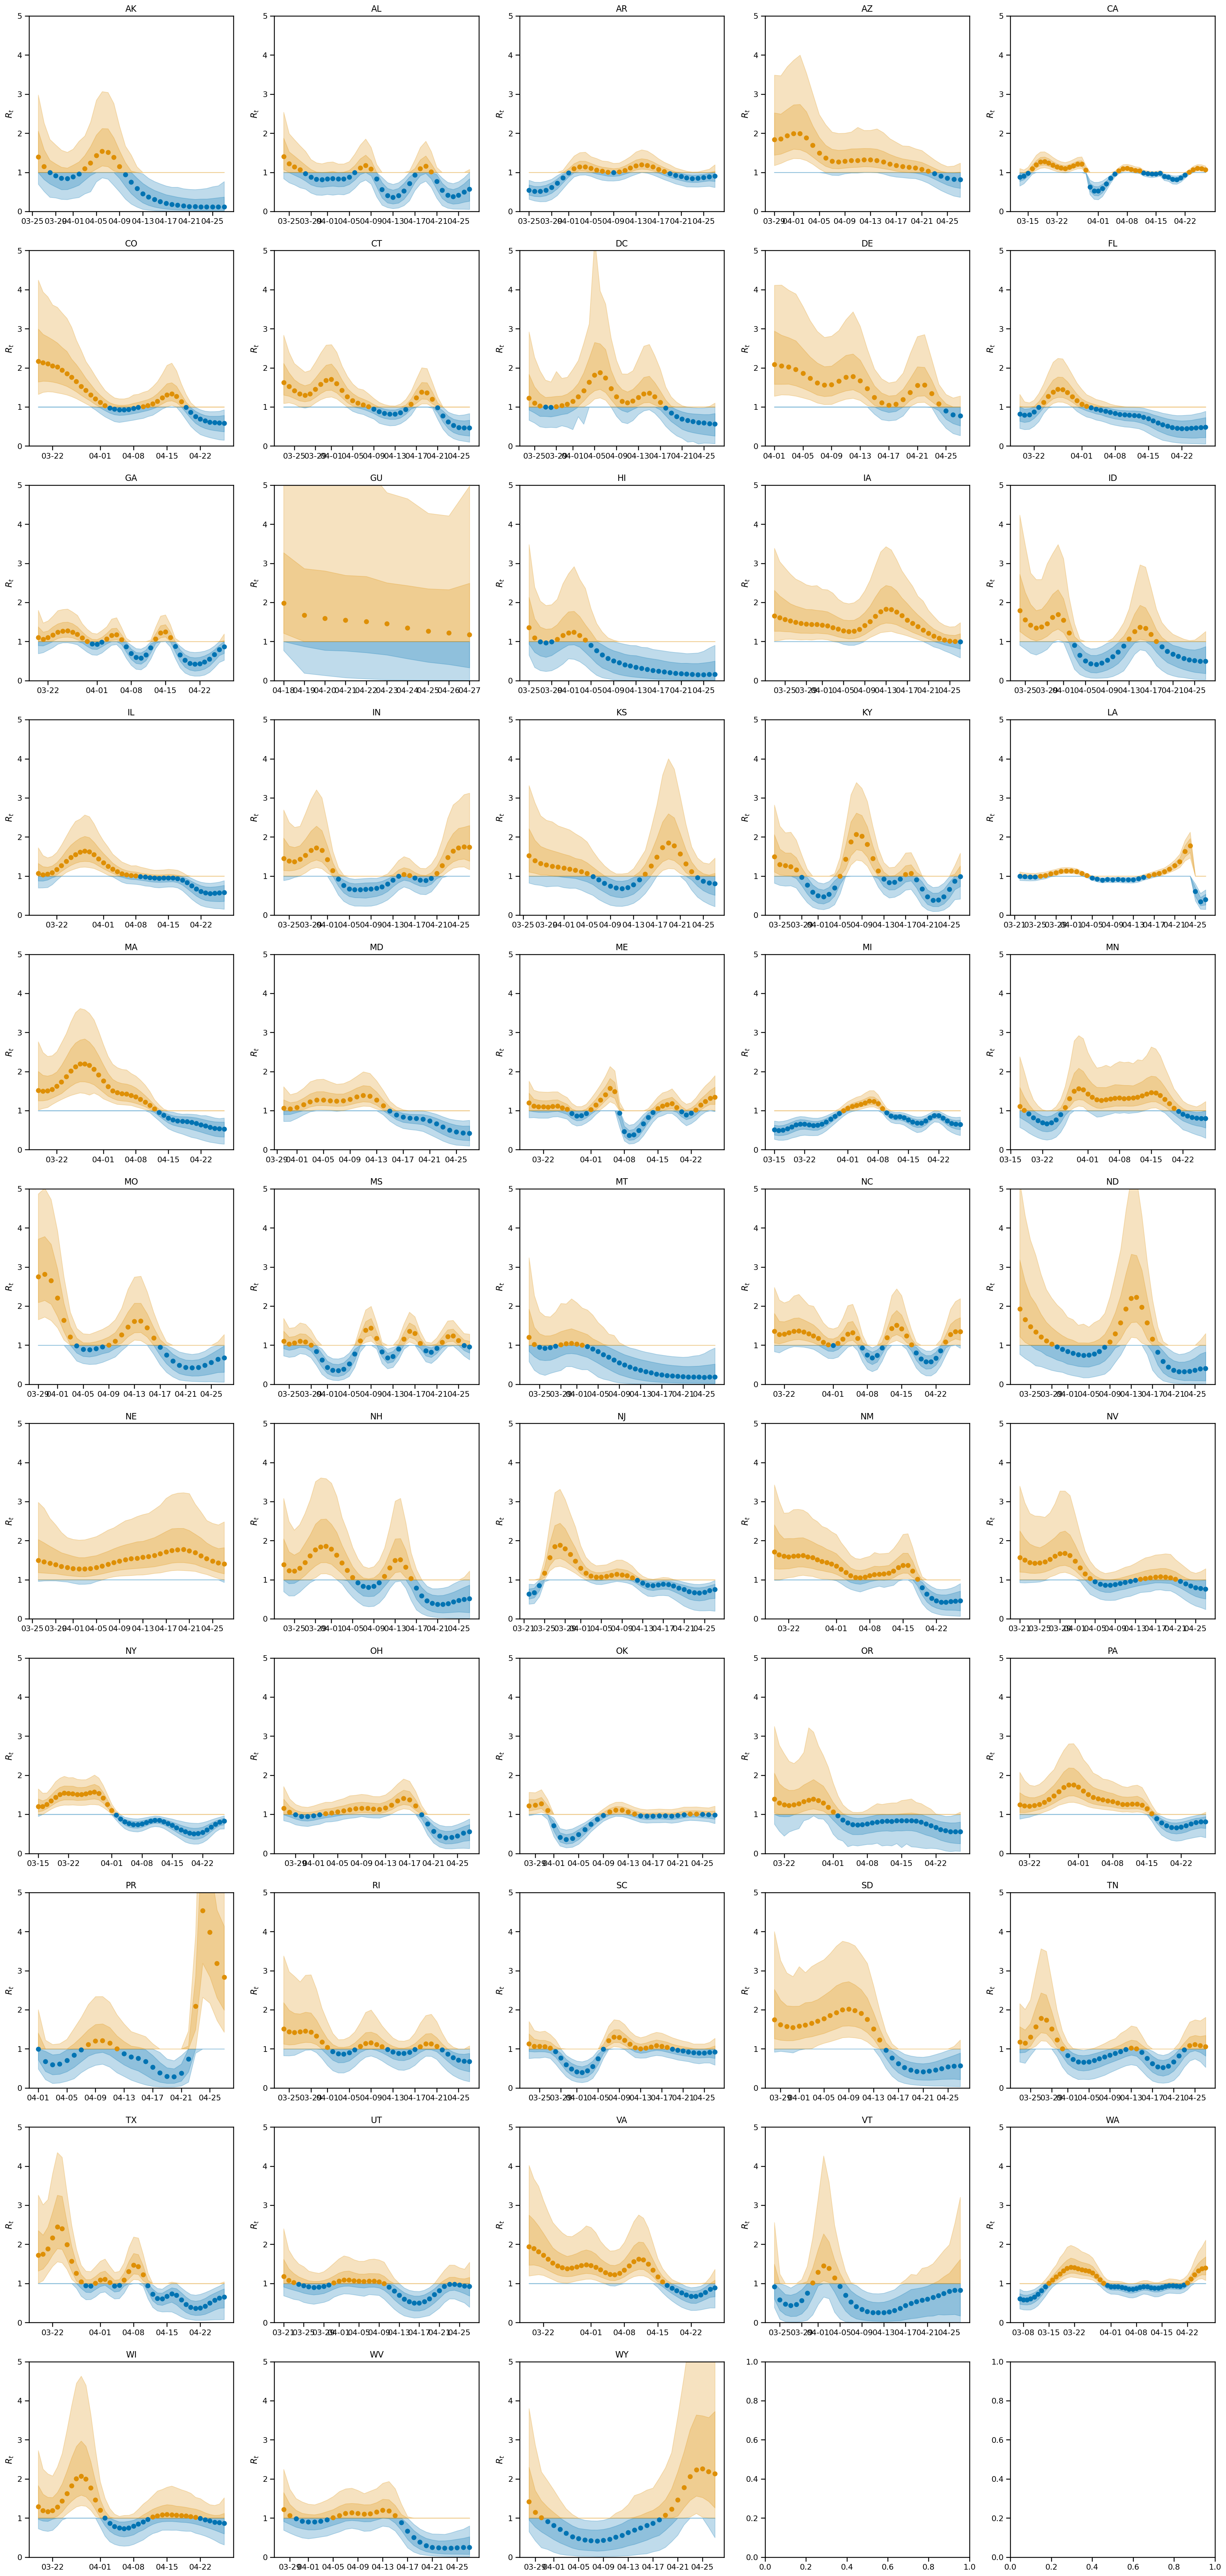

In [22]:
nc = 5
nr = 11

fig, axes = subplots(nrows=nr, ncols=nc, figsize=(30, 66))

for (k,fit), ax in zip(state_fits.items(), axes.flatten()):
    m = median(fit.posterior.Rt, axis=(0,1))
    hh = percentile(fit.posterior.Rt, 97.5, axis=(0,1))
    h = percentile(fit.posterior.Rt, 84, axis=(0,1))
    l = percentile(fit.posterior.Rt, 16, axis=(0,1))
    ll = percentile(fit.posterior.Rt, 2.5, axis=(0,1))

    x = fit.posterior.Rt_dates.values

    good_dates = m <= 1.0
    bad_dates = m > 1.0

    ax.plot_date(x[good_dates], m[good_dates], xdate=True, color=sns.color_palette()[0])
    ax.fill_between(x, where(h<1, h, 1) , where(l<1, l, 1), alpha=0.25, color=sns.color_palette()[0])
    ax.fill_between(x, where(hh<1, hh, 1) , where(ll<1, ll, 1), alpha=0.25, color=sns.color_palette()[0])

    ax.plot_date(x[bad_dates], m[bad_dates], xdate=True, color=sns.color_palette()[1])
    ax.fill_between(x, where(h>1, h, 1) , where(l>1, l, 1), alpha=0.25, color=sns.color_palette()[1])
    ax.fill_between(x, where(hh>1, hh, 1) , where(ll>1, ll, 1), alpha=0.25, color=sns.color_palette()[1])

    date_fmt = md.DateFormatter('%m-%d')
    ax.xaxis.set_major_formatter(date_fmt)
    
    ax.set_title(k)
    ax.set_ylabel(r'$R_t$')
    ax.set_ylim(0, 5)

These look *terrible*; a glance at the data suggests that the total number of tests is not as well curated as the number of positive tests---many states show kinks, jumps, or even *negative* numbers of tests in a given day.  The smoothing helps a bit, but not enough to make me believe the above plots.

Here is a nice plot that shows the distribution of $R_t$ at the latest day of sampling, ordered by its median value:

In [23]:
nc = 4
nd = 1000

d = {'state': [], 'Rt': []}
for k, f in state_fits.items():
    d = {'state': concatenate((d['state'], (k,)*(nc*nd))), 
         'Rt': concatenate((d['Rt'], f.posterior.Rt[:,:,-1].values.flatten()))}
df = pd.DataFrame(d)

sort_Rts = [median(fit.posterior.Rt[:,:,-1]) for fit in state_fits.values()]
state_order = array(list(state_fits.keys()))[argsort(sort_Rts)]

Compare to http://rt.live:

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52]),
 <a list of 53 Text major ticklabel objects>)

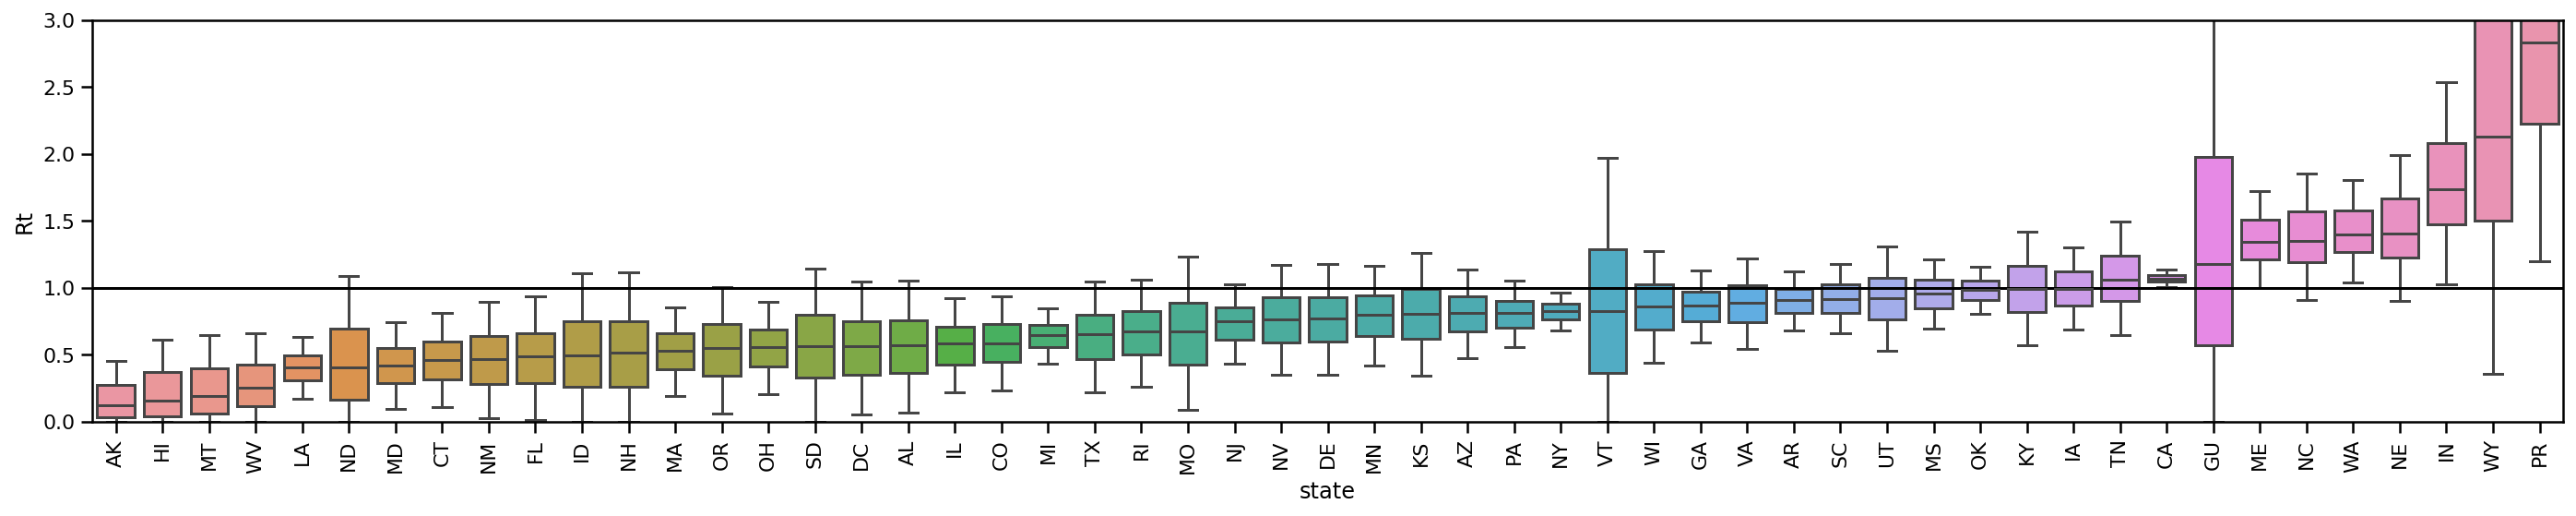

In [24]:
figure(figsize=(24,4))
sns.boxplot(x='state', y='Rt', data=df, order=state_order, fliersize=0, whis=1.0/1.35, )
axhline(1, color='k')
axis(ymin=0, ymax=3)
xticks(rotation=90)